In [89]:
import chess
import chess.uci
import chess.pgn
import os
import csv
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
import pandas as pd
import math
import statistics
import ast
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json
from sklearn import preprocessing
import pickle

%matplotlib inline


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
import seaborn as sns 
from matplotlib.colors import ListedColormap
import matplotlib.style as style
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

In [3]:
def get_perf_df(event = 'Rated Classical game'):
    df = pd.read_csv("/Users/tylerahlstrom/Desktop/GitHub/DI_proposal/data/stockfish_performances_DC_2_1.csv")
    df = df.drop(df[df.event != event].index)
    return df

In [4]:
def split_perfs(joint_perf_df):
    new_headers = ['elo', 'chosen_evals', 'option_evals', 'opp_elo', 'win', 'acc_name']
    split_df = pd.DataFrame(columns = new_headers)
    for index, row in joint_perf_df.iterrows():
        if len(row['result']) is 3:
            split_df = split_df.append({'elo': row['elo_w'], 'chosen_evals' : row['chosen_moves_eval_w'], 'option_evals' : row['available_moves_eval_w'], 'opp_elo': row['elo_b'], 'result': row['result'][0], 'acc_name': row['acc_name_w']}, ignore_index=True)
            split_df = split_df.append({'elo': row['elo_b'], 'chosen_evals' : row['chosen_moves_eval_b'], 'option_evals' : row['available_moves_eval_b'], 'opp_elo': row['elo_w'], 'result': row['result'][2], 'acc_name': row['acc_name_b']}, ignore_index=True)
    return split_df

In [5]:
def convert_json_to_list(df):
    for index, row in df.iterrows():
        row['chosen_evals'] = json.loads(row['chosen_evals'])
        row['option_evals'] = json.loads(row['option_evals'])
    return df

In [6]:
def get_list_of_chosen_moves(dict_of_move_dict): #e.g. {u'11': {u'move_rank': 2, u'cp_scor#
    lol_of_moves = []
    for key, d_move in dict_of_move_dict.items():
        lol_of_moves.append([key, d_move])
    lol_of_moves.sort(key=lambda x: int(x[0]))
    return lol_of_moves

In [7]:
def get_list_of_list_of_available_moves(dict_of_options_dict): # e.g. {u'24': {u'd7e8': {u'cp_score': -674, u'mate_s...
    lolol_of_options  = []
    for key, d_options in dict_of_options_dict.items():
        lol_of_options = []
        for key2, d_option in d_options.items():
            lol_of_options.append([key2, d_option])
        lol_of_options.sort(key=lambda x: int(x[1]['rank']))
    
        lolol_of_options.append([key, lol_of_options])
    lolol_of_options.sort(key=lambda x: int(x[0][0]))
    return lolol_of_options

In [8]:
def get_list_of_rank_percentiles(list_of_moves):
    list_of_rank_percentiles = []
    for move in list_of_moves:
        rank = int(move[1]['move_rank'])
        num_options = int(move[1]['num_move_options'])
        chunk = float(1)/float(num_options)
        percentile = 1.0 - (float(rank-1) * chunk)
        list_of_rank_percentiles.append(percentile)
    return list_of_rank_percentiles

In [9]:
def get_list_of_move_cps(list_of_moves):
    list_of_cps = []
    for move in list_of_moves:
        cp = move[1]['cp_score']
        list_of_cps.append(cp)
    return list_of_cps

In [10]:
def get_list_of_move_mates(list_of_moves):
    list_of_mates = []
    for move in list_of_moves:
        mate = move[1]['mate_score']
        list_of_mates.append(mate)
    return list_of_mates

In [11]:
def get_list_of_option_cps(list_of_av_moves):
    #print(list_of_av_moves)
    lol_of_option_cps = []
    for move in list_of_av_moves:
        options_cps = []
        for option in move[1]:
            options_cps.append(option[1]['cp_score'])
        lol_of_option_cps.append(options_cps)
    
    #print(lol_of_option_cps)
    return lol_of_option_cps

In [12]:
def get_list_of_dist_percentiles(move_cps, option_cps):
    dist_scores = []
    for i in range(len(move_cps)):
        avg_cp = sum([x for x in option_cps[i] if x is not None])/float((len([x for x in option_cps[i] if x is not None])+0.1))
        if move_cps[i] is None:
            move_cps[i] = -2000
        if avg_cp is None:
            avg_cp = -300
        comparison_cp = move_cps[i] - avg_cp
        dist_scores.append(comparison_cp)
        #percentile = float(better_than_cp)/min(float(total_cp), -1)
        #dist_percentiles.append(percentile)
    
    return dist_scores

In [13]:
def get_elo_system_prediction(result, opp_elo):
    k_factor = 40
    base_elo = 1560
    Ea = 1./(1.+10.**((opp_elo - base_elo)/400.))
    Rnew = base_elo + k_factor*(float(result) - Ea)
    return Rnew

In [14]:
def get_raw_data_df(event):
    data_df = get_perf_df(event)
    data_df = data_df.drop_duplicates()
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    data_df = split_perfs(data_df)
    data_df = convert_json_to_list(data_df)
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    return data_df


In [38]:
def get_desired_data(complete_data_df, to_select = ['rank_percentiles', 'dist_percentiles', 'cps', 'result', 'opp_elo', 'acc_name', 'mates']):
    i=0
    X_selected_ldl = [] #X_selected_ldl is a list of dictionaries of lists, easiest way (i think) to trak all the relevant data
    y = []#elo targets
    for index, row in complete_data_df.iterrows():
        if i == 0:
            print(index, row)
        i += 1
        row_dict = {}
        
        ch_moves = get_list_of_chosen_moves(row['chosen_evals'])
        av_moves = get_list_of_list_of_available_moves(row['option_evals'])
        
        if 'rank_percentiles' in to_select:
            rank_percentiles = get_list_of_rank_percentiles(ch_moves)
            row_dict['rank_percentiles'] = rank_percentiles
        if 'cps' in to_select: #TO ADD: cp percentiles (e.g., just how much worse would the worst move have been?)
            cps = get_list_of_move_cps(ch_moves)
            row_dict['cps'] = cps
        if 'dist_percentiles' in to_select:
            option_cps = get_list_of_option_cps(av_moves)
            dis_percentiles = get_list_of_dist_percentiles(cps, option_cps)
            row_dict['dist_percentiles'] = dis_percentiles
        if 'opp_elo' in to_select:
            row_dict['opp_elo'] = row['opp_elo']
        if 'result' in to_select:
            row_dict['result'] = row['result']
        if 'acc_name' in to_select:
            row_dict['acc_name'] = row['acc_name']
        if 'mates' in to_select:
            mates = get_list_of_move_mates(ch_moves)
            row_dict['mates'] = mates
        
        elo = row['elo']
        X_selected_ldl.append(row_dict)
        y_entry = []
        y_entry.append(elo)
        elo_system_prediction = get_elo_system_prediction(row_dict['result'],row_dict['opp_elo'])
        y_entry.append(int(elo_system_prediction))
        y.append(y_entry)

    return X_selected_ldl, y #X_selected_ldl is a list of dictionaries of lists

In [16]:
def remove_short_games(X, y):
    i = 0
    while i < (len(X)):
        if len(X[i]['cps']) < 30:
            X.pop(i)
            y.pop(i)
            i -= 1
        i+=1
    return X, y
    

In [58]:
def extract_features(X_input): #X should be at least length 30
    
    eg_cut = 7 #early game cutoff
    mg_cut = 7
    #eg_cut = ... the rest 
    
    X = []
    for i in range (len(X_input)):
        X_entry = []
        
        #RANK
        rank_list = X_input[i]['rank_percentiles'] 
        
        rank_bestmove_score = sum(1 for percential in rank_list if percential == 1.0) / float(len(rank_list))
        X_entry.append(rank_bestmove_score)
        
        rank_mistake_score = sum(1 for percential in rank_list if percential < 0.7 and percential > 0.5) / float(len(rank_list))
        X_entry.append(rank_mistake_score)
        
        blunder_score_rank = sum(1 for percential in rank_list if percential < 0.5) / float(len(rank_list))
        X_entry.append(blunder_score_rank) 
        

        
        
        
        
        
#         avg_eg_rank = sum(rank_list[:eg_cut]) / eg_cut
#         X_entry.append(avg_eg_rank)
        
#         avg_mg_rank = sum(rank_list[eg_cut:eg_cut+mg_cut]) / mg_cut
#         X_entry.append(avg_mg_rank)
        
#         avg_lg_rank = sum(rank_list[eg_cut+mg_cut:]) / (len(rank_list) - (eg_cut+mg_cut))
#         X_entry.append(avg_lg_rank)
        
        ##CP
        cp_list = X_input[i]['cps']
        cp_list = [x for x in cp_list if x is not None]
        
        avg_cp = sum(cp_list) / len(cp_list)
        X_entry.append(avg_cp)
        
        avg_mg_cp = sum(cp_list[eg_cut:eg_cut+mg_cut]) / mg_cut
        X_entry.append(avg_mg_cp)
        
        std_cp = statistics.stdev(cp_list)
        X_entry.append(std_cp)
        
        
        #X_entry.append(99)
        
        #DIST
        dist_list = X_input[i]['dist_percentiles']
        dist_list = [x for x in dist_list if x is not None]
        
        avg_dist = sum(dist_list) / len(dist_list)
        X_entry.append(avg_dist)
        
        avg_eg_dist = sum(dist_list[:eg_cut]) / eg_cut
        X_entry.append(avg_eg_dist)
        
        avg_mg_dist = sum(dist_list[eg_cut:eg_cut+mg_cut]) / mg_cut
        X_entry.append(avg_mg_dist)
        
        avg_lg_dist = sum(dist_list[eg_cut+mg_cut:]) / (len(dist_list) - (eg_cut+mg_cut))
        X_entry.append(avg_lg_dist)

        ##MATES
        
        mate_list = X_input[i]['mates']
        
        mate_blunders = sum(1 for each in mate_list if each and each[0:2] == 'DB')
        X_entry.append(mate_blunders)
        
        mate_finds = sum(1 for each in mate_list if each and each[0:2] == 'AB')
        X_entry.append(mate_finds)
        
        
        ##BEST MOVES
#         rank_bestmove_score = sum(1 for percential in rank_list if percential == 1.0) / float(len(rank_list))
#         X_entry.append(rank_bestmove_score)
        
        
        
        ##LENGTH
        X_entry.append(len(X_input[i]['rank_percentiles'])) ##or any of the sublists being used
        
        #OPPONENT AND RESULT
        #X_entry.append(float(X_input[i]['opp_elo']))
        X_entry.append(float(X_input[i]['result']) * 2 - 1)
        
        #PILE IT ON
        for i in range(30):
            X_entry.append(rank_list[i])
        
        
        X.append(X_entry)
    return X
    #first 5, second 5, last all, average, standard deviation

In [59]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [60]:
def split_data(X, y, test_percentage = 10):
    total = len(X)
    
    X, y = unison_shuffled_copies(X,y)
    
    train_size = int(total * (100-test_percentage)/100)

    X_train = X[:train_size]
    y_train_almost = y[:train_size]
    y_train = np.array([z[0] for z in y_train_almost])

    X_test = X[train_size:]
    y_test_almost = y[train_size:]
    y_test = np.array([z[0] for z in y_test_almost])
    y_elo_sys_pred = np.array([z[1] for z in y_test_almost])

    
    return X_train, X_test, y_train, y_test, y_elo_sys_pred

In [61]:
def renorm_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [21]:
def get_data(event = 'Rated Classical game'):
    data_df = get_raw_data_df(event)
    X, y = get_desired_data(data_df)
    X, y = remove_short_games(X, y)
    return X, y

### Extract features

In [39]:
X_raw, y_raw = get_data(event = 'Rated Classical game')

(0, elo                                                          1471
chosen_evals    {u'24': {u'move_rank': 1, u'cp_score': 292, u'...
option_evals    {u'24': {u'f2f4': {u'cp_score': -236, u'mate_s...
opp_elo                                                      1497
win                                                           NaN
acc_name                                                   saurin
result                                                          1
Name: 0, dtype: object)


In [40]:
R = 98
avg_num_moves = sum(len(entry['cps']) for entry in X_raw) / len(X_raw)
print("Average number of moves: " + str(avg_num_moves))


Average number of moves: 44


In [62]:
sample_num = 12
#print(X_raw[sample_num])
X = np.array(extract_features(X_raw))
#print(X[sample_num])
y = np.array(y_raw)


X_train, X_test, y_train, y_test, y_elo_sys_pred = split_data(X,y)
print('Sample X, y: \n{a} \n{b}'.format(a = X_train[sample_num], b = y_train[sample_num]))
print("\nX_train: {a} \nX_test: {b} \ny_train: {c} \ny_test: {d}".format(a = X_train.shape, b = X_test.shape, c = y_train.shape, d = y_test.shape))
X_train, X_test = renorm_data(X_train, X_test)

print("Average elo: " + str(sum(y_test) / len(y_test)))


Sample X, y: 
[ 4.10714286e-01  3.57142857e-02  5.35714286e-02 -1.00000000e+02
 -8.10000000e+01  1.45264774e+02  4.20812895e+02  2.68834334e+02
  4.35408657e+02  4.43710028e+02  0.00000000e+00  0.00000000e+00
  5.60000000e+01  1.00000000e+00  1.00000000e+00  9.65517241e-01
  7.40740741e-01  1.00000000e+00  8.62068966e-01  9.65517241e-01
  7.58620690e-01  8.21428571e-01  9.39393939e-01  8.10810811e-01
  9.72222222e-01  1.00000000e+00  9.73684211e-01  9.14285714e-01
  4.51612903e-01  3.61111111e-01  9.44444444e-01  6.11111111e-01
  7.50000000e-01  2.89473684e-01  9.16666667e-01  9.70588235e-01
  1.00000000e+00  5.52631579e-01  1.00000000e+00  8.91891892e-01
  1.00000000e+00  1.00000000e+00  1.00000000e+00  9.14285714e-01] 
1742

X_train: (1845, 44) 
X_test: (205, 44) 
y_train: (1845,) 
y_test: (205,)
Average elo: 1575


In [63]:
print ("X_train: " + str(X_train.shape))
print ("X_test: " + str(X_test.shape))
print ("y_train: " + str(y_train.shape))
print ("y_test: " + str(y_test.shape))

X_train: (1845, 44)
X_test: (205, 44)
y_train: (1845,)
y_test: (205,)


In [43]:
# for i in range(len(X_train[0])):
#     X_plot = np.array([entry[i] for entry in X])
#     slope, intercept, r_value, p_value, std_err = stats.linregress(y, X_plot)
#     line = slope*y+intercept
#     plt.plot(y,X_plot,'o', y, line)
#     #np.poly1d(np.polyfit(X_plot, y, 1))
#     plt.show()

### Create Models

In [44]:
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.feature_selection import SelectKBest

# from __future__ import print_function
# import collections
# import os
# import tensorflow as tf
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
# from keras.layers import LSTM
# from keras.optimizers import Adam
# from keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint
# import numpy as np
# import argparse

In [45]:
selector = SelectKBest(k = 45)

nn_reg = MLPRegressor(hidden_layer_sizes=(200,200,150,),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        max_iter=1000000,
        #learning_rate_init=0.001,
        alpha=0.0001,
        early_stopping=True,
        shuffle=True,
        warm_start=False)



nn_est = Pipeline(steps=[('selector', selector),
                         ('nn_reg', nn_reg)])


In [46]:
nn_est.fit(X_train, y_train)
y_pred = nn_est.predict(X_test)

print("Training set r^2: " + str(nn_est.score(X_train, y_train)))
print("Test set r^2: " + str(nn_est.score(X_test, y_test)))
print("Average absolute error: " + str(math.sqrt(mean_squared_error(y_test, y_pred))))

Training set r^2: 0.5069053524137763
Test set r^2: -0.13683018352477383
Average absolute error: 253.073239702


In [47]:
# sorted(sklearn.metrics.SCORERS.keys())

In [66]:
scaler = StandardScaler()
selector = SelectKBest(k = 45)
linaer_reg = LinearRegression()
ridge_reg = Ridge()

linear_est = Pipeline(steps=[('scaler', scaler),
                            #('selector', selector),
                            ('linaer_reg', linaer_reg)])

linear_est.fit(X_train, y_train)
#linear_est.predict(X)
#print(linear_est.score(X_train, y_train))
print(linear_est.score(X_test, y_test))
print(linaer_reg.coef_)
y_pred = linear_est.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(y_test, y_pred))))

0.3180676943590829
[ 12.37127862  -0.62962224 -49.69260986   4.84893375  29.72465927
 -20.73560911  15.19455421 -12.08608412  -6.24014454  12.97105147
 -15.78842156  -5.93291802  36.41673594 -25.04292126  -9.03634213
  14.19916663  17.82407214  15.88686709  13.68256784   8.32935635
   3.49953569   2.64073274  11.59470695  12.78768822   4.14625714
  -0.13163453   8.39949518   5.50189338   5.38571227  14.39553484
   0.25484172  15.01018947   3.62565117   1.65208239   2.57739295
   3.52968398  13.63734413   5.00365898   7.06657553  13.82032962
   0.67441065   1.6321585    9.55725836  -5.39784947]
Average absolute error: 207.97082948


In [67]:
linear_reg_null = LinearRegression()

null_model = Pipeline(steps=[('linaer_reg', linear_reg_null)])

X_null_train = [entry[-2:] for entry in X_train]
X_null_test = [entry[-2:] for entry in X_test]

null_model.fit(X_null_train, y_train)
#linear_est.predict(X)
null_model_pred = null_model.predict(X_null_test)
print(null_model.score(X_null_test, y_test))
print(linear_reg_null.coef_)
y_pred_null = null_model.predict(X_null_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(y_test, y_pred_null))))

0.0031247068782424003
[24.73634462 11.36458689]
Average absolute error: 251.450328698


## Cross Validation (vs. Elo)

In [68]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def get_r2(y_test, y_pred):
    xs = np.array(y_test, dtype=np.float64)
    ys = np.array(y_pred, dtype=np.float64)

    def best_fit_slope_and_intercept(xs,ys):
        m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
             ((mean(xs)*mean(xs)) - mean(xs*xs)))
        b = mean(ys) - m*mean(xs)
        return m, b

    def squared_error(ys_orig,ys_line):
        return sum((ys_line - ys_orig) * (ys_line - ys_orig))

    def coefficient_of_determination(ys_orig,ys_line):
        y_mean_line = [mean(ys_orig) for y in ys_orig]
        squared_error_regr = squared_error(ys_orig, ys_line)
        squared_error_y_mean = squared_error(ys_orig, y_mean_line)
        return 1 - (squared_error_regr/squared_error_y_mean)

    m, b = best_fit_slope_and_intercept(xs,ys)
    regression_line = [(m*x)+b for x in xs]

    r_squared = coefficient_of_determination(ys,regression_line)
    return (r_squared)

In [69]:
y_pred = linear_est.predict(X_test)
model_error = math.sqrt(mean_squared_error(y_test, y_pred))
elo_sys_error = math.sqrt(mean_squared_error(y_test, y_elo_sys_pred))


print("Average model error: " + str(model_error))
print("Average elo system error: " + str(elo_sys_error))
print("percentage improvement: " + str('%.2f' % ((get_r2(y_test, y_pred) - get_r2(y_test, y_elo_sys_pred))
                                                  /get_r2(y_test, y_elo_sys_pred) * 100) + '%'))

Average model error: 207.97082948
Average elo system error: 243.294301358
percentage improvement: 62.09%


## Plot data

In [54]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
import seaborn as sns 
from matplotlib.colors import ListedColormap
import matplotlib.style as style
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 144
style.use('seaborn-talk') 
sns.set_style("white")
sns.set_context("poster", font_scale=1.5,)
font = {'fontname':'Adobe Hebrew'}

plt.minorticks_off()

# print(y_pred)
# print(y_elo_sys_pred)
plt = sns.distplot(y_elo_sys_pred, hist = False, kde=True, color = 'red', kde_kws = {'shade': True, 'linewidth': 1}, label = 'standard system predictions')
plt = sns.distplot(y_pred, hist = False, kde=True, color = 'blue',kde_kws = {'shade': True, 'linewidth': 1}, label = 'my model predictions')
plt = sns.distplot(list(y_test), hist = False, kde=True, color = 'yellow',kde_kws = {'shade': True, 'linewidth': 1}, label = 'target values')
plt.legend(prop={'size': 8})

x_ticks_int = [800, 1000, 1200, 1400, 1600, 1800, 2000, 2200]
x_ticks_str = [str(x) for x in x_ticks_int]
    
#plt.xticks(x_ticks_int, x_ticks_str, rotation='horizontal', fontsize=14, fontname = 'Lucida Console')
# print([x for x in y_pred])
# print([x for x in y_elo_sys_pred])
print([x for x in y_test])

[[1471 1576]]
[[ 3.75000000e-01  0.00000000e+00  0.00000000e+00 -4.20000000e+02
  -5.60000000e+01  7.77861997e+02 -3.04625189e+02  1.73336371e+02
   3.47168708e+02 -7.43974534e+02  0.00000000e+00  0.00000000e+00
   3.20000000e+01  1.00000000e+00  8.50000000e-01  1.00000000e+00
   9.33333333e-01  7.09677419e-01  1.00000000e+00  9.66666667e-01
   9.72222222e-01  8.91891892e-01  1.00000000e+00  9.77777778e-01
   8.33333333e-01  8.40000000e-01  9.13043478e-01  1.00000000e+00
   9.75000000e-01  9.52380952e-01  1.00000000e+00  9.13043478e-01
   9.81481481e-01  8.60000000e-01  1.00000000e+00  1.00000000e+00
   8.47457627e-01  9.83870968e-01  1.00000000e+00  9.80392157e-01
   9.27272727e-01  1.00000000e+00  9.71428571e-01  1.00000000e+00]]
      % best move  % blunders  % mistakes    avg cp  avg mid game strength  \
elo                                                                          
800      0.347958    0.428909    0.361589  0.470681               0.711878   
1000     0.368624    0.4

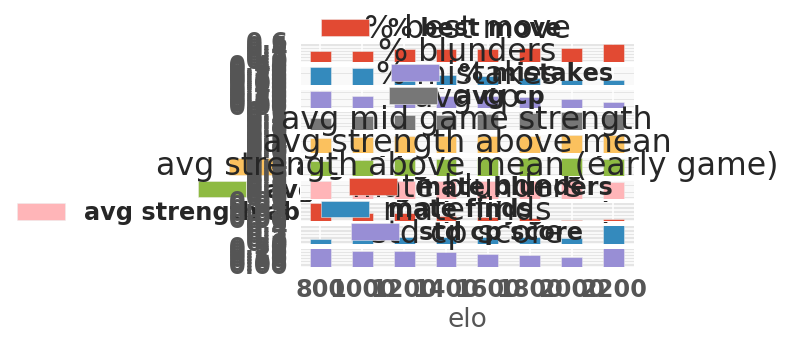

In [94]:
print(y[0:1])
print(X[0:1])
#new_headers = ['elo', 'chosen_evals', 'option_evals', 'opp_elo', 'win']
#    split_df = pd.DataFrame(columns = new_headers)

x_df = pd.DataFrame({'% best move':X[:,0],'% mistakes':X[:,1], '% blunders':X[:,2], 'avg cp':X[:,3],
                    'avg mid game strength':X[:,4], #'avg end game strength':X[:,5],'avg cp score':X[:,6], 
                    #'avg mid game cp score':X[:,4],
                    'std cp score':X[:,5], 'avg strength above mean':X[:,6],
                    'avg strength above mean (early game)':X[:,7], #'avg strength above mean (mid game)':X[:,10],
                    #'std cp score (end game)':X[:,12]})
                     'mate blunders':X[:,10],'mate finds':X[:,12]})
y_df = pd.DataFrame({'elo':[e[0] for e in y]})
#data = np.concatenate(y, X, ...), axis=1)
# for i in range(len(y)):
#     data.append([X[i].insert(0, y[i])])


x_npdata = x_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(x_npdata)
x_df = pd.DataFrame(data_scaled, columns = x_df.columns)
y_df['elo'] = pd.cut(y_df['elo'], [800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400], labels=[800, 1000, 1200, 1400, 1600, 1800, 2000, 2200])
df = pd.concat([y_df, x_df], axis=1)
df = df.dropna()
#df2 = df[['elo','% mistakes']].copy()
#ax = df2.plot.bar(rot=0)
df = df.groupby(['elo']).mean()
print(df)
df.to_pickle('feature_df')
# n = df.columns['elo']

# # Drop that column
# df.drop(n, axis = 1, inplace = True)

# new_index = pd.Series([800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400])
# df[0] = new_index
#df
#ax = df.plot.bar(y='% mistakes', rot=0)
#print(df)

axes = df.plot.bar(rot=0, subplots=True)
axes[1].legend(loc=2)  # doctest: +SKIP

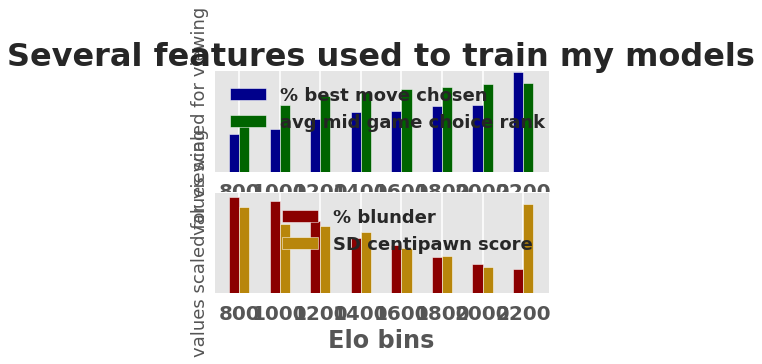

In [95]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = df['% best move'].values.tolist()
bars1 = [x - 0.2 for x in bars1]
bars2 = df['avg mid game strength'].values.tolist()
bars2 = [x - 0.5 for x in bars2]

bars3 = df['% blunders'].values.tolist()
bars4 = df['std cp score'].values.tolist()
bars4 = [(x - 0.1) *2 for x in bars4]
#bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.subplot(2, 1, 1)
plt.bar(r1, bars1, color='darkblue', width=barWidth, edgecolor='white', label='% best move chosen')
plt.bar(r2, bars2, color='darkgreen', width=barWidth, edgecolor='white', label='avg mid game choice rank')
#plt.xlabel('', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], df.index.tolist(), size = 20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)
plt.yticks([])
plt.ylabel('values scaled for viewing', size = 18)
plt.legend(loc = 2, prop={'size': 18})
plt.margins(x=0.05)
plt.title("Several features used to train my models", fontweight='bold', size = 32)

#plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
plt.subplot(2, 1, 2)
plt.bar(r1, bars3, color='darkred', width=barWidth, edgecolor='white', label='% blunder')
plt.bar(r2, bars4, color='darkgoldenrod', width=barWidth, edgecolor='white', label='SD centipawn score')
plt.legend(prop={'size': 18})

#plt.xticks(ticks=None, labels=None)
# Add xticks on the middle of the group bars
plt.xlabel('Elo bins', fontweight='bold', size = 24)
plt.xticks([r + barWidth for r in range(len(bars1))], df.index.tolist(), size = 20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)
plt.yticks([])
plt.ylabel('values scaled for viewing', size = 18)
plt.margins(x=0.05)


# Create legend & Show graphic

plt.show()


In [ ]:
df=df.astype(k)
df.plot(x='% best move', y='elo', kind='bar') 
plt.show()

In [ ]:
group_data = []

num_bins = 6

bins = np.linspace(1000, 2500, num_bins)

for bin in range (num_bins):
    group_data_point = []
    group_data_point.append(bins[bin])
    min=1000.0+(300*bin)
    group_count = 0
    group_mean = []
    group_std = []
    for point in data_points:
        if (point[0].item() > min) & (point[0].item() < min + 300):
            group_count +=1
            if not math.isnan(float(point[4])):
                group_mean.append(point[4])
            if not math.isnan(float(point[5])):
                group_std.append(point[5])
    group_mean = np.mean(array(group_mean))
    group_std = np.mean(array(group_std))

    if math.isnan(float(group_mean)):
        print(group_mean)
    if math.isnan(float(group_std)):
        print(group_std)

    group_data_point.append(group_mean)
    group_data_point.append(group_std)
    group_data.append(group_data_point)

binned_data = array(group_data)


In [ ]:
%matplotlib qt

N = binned_data.shape[0]
print(N)
elos = [int(el[0]) for el in binned_data]
means = [el[1] for el in binned_data]
stds = [el[2] for el in binned_data]

print(elos)
print(means)
print(stds)



### scaling for viewing
means = [el*0.8 for el in means]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

ind = np.arange(N)  
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, means, width, color='seagreen')
rects2 = ax.bar(ind + width*.8, stds, width, color='darkslateblue')


ax.set_ylabel('Values (scaled for viewing)')
ax.set_xlabel('Elo bins ')

ax.set_title('Features of evaluated moves')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(elos)

plt.tick_params(left='off', labelleft='off')

ax.legend((rects1[0], rects2[0]), ('Average move strength', 'Standard deviation of move strength'))


plt.axhline(0, color='black')
plt.show()

In [1089]:
#only set up to work when there is no scaling, sensitive to the data
y_pred_null = np.array([a[-2] for a in X_test])
print(r2_score(y_test, y_pred_null))

elo_step = 50
y_adjustment = np.array([(a[-1]*2-1)*elo_step for a in X_test])
y_pred_null = y_pred_null + y_adjustment
print(y_pred_null[0:10])
print(r2_score(y_test, y_pred_null))
print("Average absolute error: " + str(math.sqrt(mean_squared_error(y_test, y_pred_null))))

0.650751126352
[ 2454.  2041.  1571.  1820.  1995.  1249.  1374.  1477.  1393.  1723.]
0.691694511392
Average absolute error: 163.50112821


### Null test for predicting elo:

In [1028]:
average_elo = np.sum(y_train)/len(y_train)
print("average elo: " + str(average_elo))

l = len(y_pred)
y_pred = []
for i in range(l):
    y_pred.append(average_elo)
print(math.sqrt(mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

average elo: 1664
293.822980269
-0.00227297372554


In [ ]:
# if using my own stockfish analysis
def get_new_elo_perfs(eval_time): 

    assert type(eval_time) is float, "Eval_time is not a float: %r" % name

    time_str = "def"

    if eval_time == 0.5:
        time_str = "halfsecond"
    if eval_time == 1.0:
        time_str = "onesecond"
    if eval_time == 3.0:
        time_str = "threeseconds"

    if time_str == "def":
        print("Eval time not available")
        return null


    elo_and_p = []
    performances_file = "/Users/tylerahlstrom/Documents/GitHub/DI_proposal/data/stockfish_performances_" + time_str + ".txt"

    with open(performances_file, 'r') as f:
        for line in f:
            listobj = ast.literal_eval(line)
            elo_and_p.append(listobj)
            
    #removing openings for now
    for item in elo_and_p:
        del item[1]
    
    #inserting win/loss from separate extraction
    winloss = []
    winloss_file_dir = "/Users/tylerahlstrom/Documents/GitHub/DI_proposal/data/winloss.txt"
    winloss_file = open(winloss_file_dir)
    filecontents = winloss_file.readlines()
    for line in filecontents:
        target_content = line.strip('\n')
        winloss.append(target_content)
        
    for i in range(len(elo_and_p)):
        elo_and_p[i].insert(1,winloss[i])
    
    
    return elo_and_p

In [ ]:
def remove_bugged_evals(provided_list):

    zero_rows = []
    i = 0
    for row in provided_list: 
        i+=1
        if row.count(0.0)>3:
            zero_rows.append(i)
    if (len(zero_rows) > 1):
        print("Found many zeros in these rows: " + str(zero_rows[1:40]))
        new_perf = [row for row in provided_list if row.count(0.0) < 2]
        new_perf = [row for row in new_perf if row[0] > 1]
        print("...and removed those rows")
    else:
        print("List is cleared of zeros bug")
        new_perf = provided_list
    return new_perf


In [ ]:
def remove_short_games(provided_list):

    threshold = 12
    
    nomove_rows = []
    i = 0
    for row in provided_list:
        if len(row) < threshold:
            nomove_rows.append(i)
        i+=1
    if (len(nomove_rows) > 0):
        print("Found less than 3 moves these rows: " + str(nomove_rows[:]))
        new_list = [row for row in provided_list if len(row) >= threshold]
        print("...and removed those rows")
    else:
        print("List has no short games")
        new_list = provided_list
    return new_list

### Get data and clean it:

In [ ]:
elo_and_performance = get_new_elo_perfs(3.0)

elo_and_performance = elo_and_performance[:1000]
print("Data points before clean-up: " + str(len(elo_and_performance)))
elo_and_performance = remove_bugged_evals(elo_and_performance)
elo_and_performance = remove_short_games(elo_and_performance)
print("Data points after clean-up: " + str(len(elo_and_performance)))
print(elo_and_performance[0:2])


### Create features:

In [ ]:
data_points = []

for item in elo_and_performance:
    dp = []
    
    #0
    dp.append(int(item[0]))
    
    #1
    dp.append(float(item[1]))

    
    arr = np.array([float(entry) for entry in item[2:]], dtype = float)
    
    average = np.mean(arr)
    #2
    dp.append(average)
    #dp.append(np.square(average))
    
    std = np.std(arr)
    #3
    dp.append(std)
    #dp.append(np.square(std))


    ten_ave = np.mean(arr[0:9])
    #4
    dp.append(ten_ave)
    #dp.append(np.square(ten_ave))

    
    std_ten = np.std(arr[0:9])
    #5
    dp.append(std_ten) 
    #dp.append(np.square(std_ten))

    
    #6
    dp.append(len(item))
    #dp.append(np.square(len(item)))

    
#    arr = np.sort(arr)
#    ave_five_worst = np.mean(arr[0:4])
    #ave_ten_worst = np.mean(arr[0:9])
    

    #7
#    dp.append(ave_five_worst)
#    dp.append(np.square(ave_five_worst))

    #8
#    dp.append(ave_ten_worst)
#    dp.append(np.square(ave_ten_worst))

#    dp.append(np.sum(arr[0:4]))
#    dp.append(np.sum(arr[0:9]))

    #print(arr)
    
    data_points.append(dp)

data_points = array(data_points)
np.set_printoptions(suppress=True)

#np.random.shuffle(data_points)
print(data_points.shape)
print(data_points[0:10])

### Create training and test set:

In [ ]:
test_percentage = 5
total = len(data_points)
train_size = int(total * (100-test_percentage)/100)


X_train = data_points[:train_size,1:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print(X_train[3])

Y_train_elo = data_points[:train_size,0]
Y_train_wl = data_points[:train_size,1]



X_test = data_points[train_size:,1:]

X_test = scaler.transform(X_test)

Y_test_elo = data_points[train_size:,0]
Y_test_wl = data_points[train_size:,1]

print ("X_train: " + str(X_train.shape))
print ("X_test: " + str(X_test.shape))
print ("Y_train: " + str(Y_train_elo.shape))
print ("Y_test: " + str(Y_test_elo.shape))

### Build models:

In [636]:
model = MLPRegressor(hidden_layer_sizes=(2,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=100000,
        #learning_rate_init=0.001,
        tol = 0.00000001,
        alpha=0.0001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)

In [637]:
model1 = MLPRegressor(hidden_layer_sizes=(4,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=100000,
        #learning_rate_init=0.001,
        tol = 0.000001,
        alpha=0.00001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)

In [ ]:
model2 = MLPRegressor(hidden_layer_sizes=(6,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=1000000,
        #learning_rate_init=0.001,
        tol = 0.00000001,
        alpha=0.00001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)

In [ ]:
model3 = MLPRegressor(hidden_layer_sizes=(8,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=100000,
        #learning_rate_init=0.001,
        tol = 0.00001,
        alpha=0.00001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)


### Train and test models:

In [ ]:
model.fit(X_train, Y_train_elo)
Y_pred = model.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))
print("Training set r^2: " + str(model.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model.score(X_test, Y_test_elo)))

In [ ]:
model1.fit(X_train, Y_train_elo)
Y_pred = model1.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))
print("Training set r^2: " + str(model1.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model1.score(X_test, Y_test_elo)))

In [ ]:
model2.fit(X_train, Y_train_elo)
Y_pred = model2.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))
print("Training set r^2: " + str(model2.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model2.score(X_test, Y_test_elo)))

In [ ]:
model3.fit(X_train, Y_train_elo)
Y_pred = model3.predict(X_test)
Y2_pred = model3.predict(X_train)
print("Average absolute error train: " + str(math.sqrt(mean_squared_error(Y_train_elo, Y2_pred))))
print("Average absolute error test: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))

print("Training set r^2: " + str(model3.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model3.score(X_test, Y_test_elo)))

# loss_values = model3.loss_curve_
# plt.plot(loss_values)
# plt.show()

# train_sizes, train_scores, test_scores = learning_curve(model3, X, Y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.figure()
# plt.title("RandomForestClassifier")
# plt.legend(loc="best")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.gca().invert_yaxis()

# # box-like grid
# plt.grid()

# # plot the std deviation as a transparent range at each training set size
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# # plot the average training and test score lines at each training set size
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# # sizes the window for readability and displays the plot
# # shows error from 0 to 1.1
# #plt.ylim(-.1,1.1)
# plt.show()



In [326]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train_elo)
Y_pred = regr.predict(X_test)
print(regr.coef_)
print(math.sqrt(mean_squared_error(Y_test_elo, Y_pred)))
print(r2_score(Y_test_elo, Y_pred))



NameError: name 'linear_model' is not defined

### Null test for predicting elo:

In [ ]:
average_elo = np.sum(Y_train_elo)/len(Y_train_elo)
print("average elo: " + str(average_elo))

l = len(Y_pred)
Y_pred = []
for i in range(l):
    Y_pred.append(average_elo)
print(math.sqrt(mean_squared_error(Y_test_elo, Y_pred)))
print(r2_score(Y_test_elo, Y_pred))


### Run best model to predict win/loss:

In [ ]:
model1.fit(X_train, Y_train_wl)
Y_pred = model1.predict(X_test)
#print(model.coef_)
print(math.sqrt(mean_squared_error(Y_test_wl, Y_pred)))
print(model1.score(X_test, Y_test_wl)) 
print(r2_score(Y_test_wl, Y_pred))

### Below lies messy graphing scripts

In [ ]:
# x = data_points[:,0]
# y = [:,1]

data = np.array(data_points)

x = data[:,0]
y = data[:,13]
# x = np.array(x)
# y = np.array(y)

color = 'r'
scale = 1.0


#plt.legend()
plt.scatter(x,y, s=scale, c=color, marker = ",", lw=0, alpha = 0.5, label = 'accounts with # games played: <15')
#plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',label="Luck")
m, b = np.polyfit(x, y, 1)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.plot(x, slope*x +intercept, '-', c = color, label = 'slope = ' + '%1.2E' % slope)
print("first order: " + str(np.power(r_value, 2)))

p = np.polyfit(x,y,2)
yfit = np.polyval(p,x)
yresid = y - yfit
SSresid = sum(np.power(yresid,2))
SStotal = (len(y)-1) * np.var(y)
rsq = 1 - SSresid/SStotal
print("second order: " + str(rsq))

p = np.polyfit(x,y,3)
yfit = np.polyval(p,x)
yresid = y - yfit
SSresid = sum(np.power(yresid,2))
SStotal = (len(y)-1) * np.var(y)
rsq = 1 - SSresid/SStotal
print("third order: " + str(rsq))

In [ ]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c = 'r'
m = 'o'

xs = [(item[1]) for item in data_points]
ys = [(item[2]) for item in data_points]
zs = [(item[0]) for item in data_points]

ax.scatter(xs, ys, zs, c=c, marker=m)

# for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)

ax.set_xlabel('mean strength')
ax.set_ylabel('std strength')
ax.set_zlabel('Elo')

plt.show()